In [2]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pixelshuffle1d import PixelShuffle1D, PixelUnshuffle1D

## Data generation

In [4]:
def generate_data(N):
    x_np = np.linspace(0, 1, N)
    f = -2 * np.ones(N)
    # f = x_np * 2

    # Initialise u
    u = np.zeros((N,1))

    # Work out matrix A
    A = np.zeros((N-2,N-2))
    for i in range(len(A)):
        A[i][i] = -2
    for i in range(len(A)-1):
        A[i][i+1] = 1
    for i in range(1,len(A)):
        A[i][i-1] = 1
    A = A / ((1/(N-1))**2)
    
    f_inside = np.reshape(f[1:N-1],(-1,1))
    
    u[1:N-1] = np.matmul(np.linalg.inv(A),f_inside)
    
    '''plt.plot(x_np,u,label="Finite Difference")
    plt.legend()
    plt.show()'''
    
    return u, x_np, f_inside, A

In [5]:
N = 20
A = np.zeros((N-2,N-2))
for i in range(len(A)):
    A[i][i] = -2
for i in range(len(A)-1):
    A[i][i+1] = 1
for i in range(1,len(A)):
    A[i][i-1] = 1
A = A / ((1/(N-1))**2)

A_total = np.zeros((N,N))
A_total[1:N-1,1:N-1] = A
A_total[0,0] = 1
A_total[1,0] = 1
A_total[18,19] = 1
A_total[19,19] = 1

In [6]:
f = -2 * np.ones(N)
f[0] = 0
f[-1] = 0
np.matmul(np.linalg.inv(A_total),np.reshape(f,(-1,1)))

array([[0.        ],
       [0.0498615 ],
       [0.09418283],
       [0.13296399],
       [0.16620499],
       [0.19390582],
       [0.21606648],
       [0.23268698],
       [0.24376731],
       [0.24930748],
       [0.24930748],
       [0.24376731],
       [0.23268698],
       [0.21606648],
       [0.19390582],
       [0.16620499],
       [0.13296399],
       [0.09418283],
       [0.0498615 ],
       [0.        ]])

In [11]:
N_low = 50
N_high = 100
u_low, x_low, f_inside, A_low = generate_data(N_low)
u_high, x_high, f_inside_high, A_high = generate_data(N_high)
GT = u_high

## Calculate prior of $u^l$

In [12]:
def gaussian_kernal(x1,x2,l,sigma):
    m, n = x1.shape[0],x2.shape[0]
    dist_matrix = np.zeros((m,n))
    for i in range(m):
        for j in range(n):
            dist_matrix[i][j] = np.sum(x1[i]-x2[j])**2
    return sigma ** 2 * np.exp(-0.5 / l ** 2 * dist_matrix)

# Define mean and covariance matrix of f
m = f_inside
G = gaussian_kernal(x_low[1:N_low-1],x_low[1:N_low-1],0.1,1)

In [13]:
# Mean and covariance matrix of u
mean_u = np.matmul(np.linalg.inv(A_low),m)
covariance_u = np.matmul(np.matmul(np.linalg.inv(A_low),G),np.linalg.inv(A_low).T)

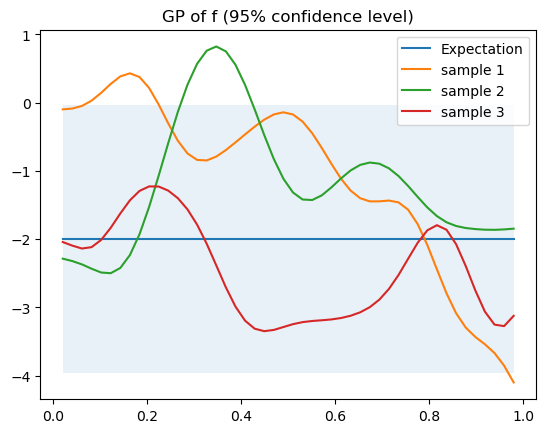

In [14]:
uncertainty = 1.96 * np.sqrt(np.diag(G))
plt.fill_between(x_low[1:49],m.ravel()+uncertainty,m.ravel()-uncertainty,alpha=0.1)
plt.plot(x_low[1:49],m.ravel(),label='Expectation')
plt.plot(x_low[1:49],np.random.multivariate_normal(m.ravel(),G),label='sample 1')
plt.plot(x_low[1:49],np.random.multivariate_normal(m.ravel(),G),label='sample 2')
plt.plot(x_low[1:49],np.random.multivariate_normal(m.ravel(),G),label='sample 3')
plt.title('GP of f (95% confidence level)')
plt.legend()
plt.show()

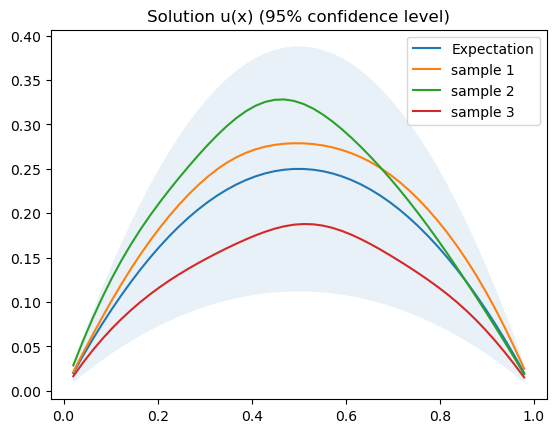

In [15]:
uncertainty = 1.96 * np.sqrt(np.diag(covariance_u))
plt.fill_between(x_low[1:49],mean_u.ravel()+uncertainty,mean_u.ravel()-uncertainty,alpha=0.1)
plt.plot(x_low[1:49],mean_u.ravel(),label='Expectation')
plt.plot(x_low[1:49],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 1')
plt.plot(x_low[1:49],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 2')
plt.plot(x_low[1:49],np.random.multivariate_normal(mean_u.ravel(),covariance_u),label='sample 3')
plt.title('Solution u(x) (95% confidence level)')
plt.legend()
plt.show()

## Upscaling network

In [16]:
class UpScale(torch.nn.Module):
    def __init__(self):
        super(UpScale, self).__init__()
        self.layer1 = torch.nn.Conv1d(in_channels=1, out_channels=6, kernel_size=3, stride=1,padding=1)
        self.act1 = torch.nn.ReLU()
        self.layer2 = torch.nn.Conv1d(in_channels=6, out_channels=6, kernel_size=3, stride=1,padding=1)
        #self.layer3 = torch.nn.Conv1d(in_channels=6, out_channels=6, kernel_size=3, stride=1,padding=1)
        self.layer4 = torch.nn.Conv1d(in_channels=6, out_channels=2, kernel_size=3, stride=1,padding=1)
        self.PReLU = torch.nn.PReLU()
        self.shuffle = PixelShuffle1D(2)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.PReLU(x)
        #x = self.layer3(x)+x1
        x = self.layer4(x)
        x = self.shuffle(x)

        # log_probs = torch.nn.functional.log_softmax(x, dim=1)

        return x

model = UpScale()
input = torch.tensor(u_low.reshape(1, 1,-1))
input = input.to(torch.float32)
print(model(input).shape)

torch.Size([1, 1, 100])


## Training

### Sum of log likelihood

In [21]:
# Initialise network
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

# Initialise parameters
sigma = 10
N_samples = 1000
epoch_number = 2000
minimum_loss = 9999
u_high = torch.tensor(u_high.reshape(1,1,-1))
u_high = u_high.to(torch.float32)

# Sample from p(u^l)
sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)

# Training Process
for epoch in range(epoch_number):
    # Calculate log likelihood based on all low-resolution samples
    log_likelihood = []
    # Log the maximum log likelihood and its index
    max_index = 0
    log_lik_max = -10000
    for i in range(N_samples):
        input = sample_ul[i]
        input = torch.tensor(input.reshape(1,1,-1))
        input = input.to(torch.float32)
        output = model(input)
        log_lik = np.log(1/(sigma*np.sqrt(2*torch.pi))) - 0.5 * ((u_high-output)/sigma)**2
        log_likelihood.append(log_lik)
        if torch.sum(log_lik) > log_lik_max:
            max_index = i
            log_lik_max = torch.sum(log_lik)
    
    # Calculate log marginal likelihood
    max_likelihood = log_likelihood[max_index]
    value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
    for i in range(1,N_samples):
        value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
    log_marginal = max_likelihood + torch.log(value)
    
    optim.zero_grad()
    loss = -torch.sum(log_marginal)
    if loss < minimum_loss:
        torch.save(model.state_dict(), 'best_model_sum_sigma10.pth')
        minimum_loss = loss
    loss.backward()
    optim.step()
    
    if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))

Epoch: 99 Loss: 322.1536560058594
Epoch: 199 Loss: 322.1535949707031
Epoch: 299 Loss: 322.1535949707031


KeyboardInterrupt: 

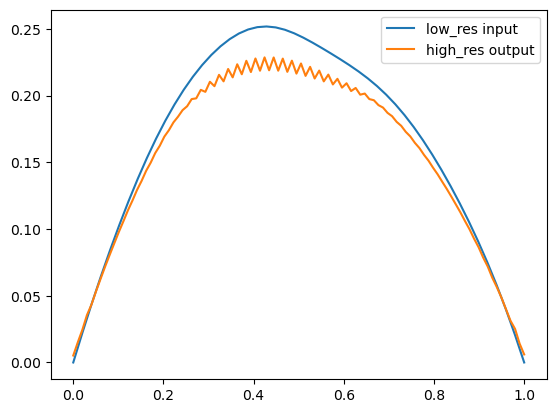

In [17]:
# Test with a random sample
model = UpScale()
model.load_state_dict(torch.load('best_model_sum.pth'))
input = np.zeros((1,N_low))
input[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
input = torch.tensor(input.reshape(1,1,-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy().reshape(-1,1)
input_random = y_input
y = output.detach().numpy().reshape(-1,1)
plt.plot(x_low,y_input,label='low_res input')
plt.plot(x_high,y,label='high_res output')
plt.legend()
plt.show()

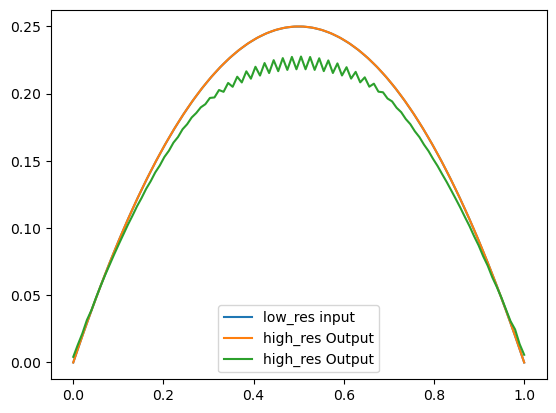

In [19]:
# Test with input A^(-1)b
model = UpScale()
model.load_state_dict(torch.load('best_model_sum.pth'))
input = u_low
input = torch.tensor(input.reshape(1,1,-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy().reshape(-1,1)
y = output.detach().numpy().reshape(-1,1)
plt.plot(x_low,y_input,label='low_res input')
plt.plot(x_high,u_high,label='high_res Output')
plt.plot(x_high,y,label='high_res Output')
plt.legend()
plt.show()

### Multivariate Gaussian

In [25]:
# Initialise network
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)

# Initialise parameters
sigma = 0.01
Sigma = torch.eye(N_high) * sigma
N_samples = 500
epoch_number = 2000
minimum_loss = 10000
u_high = torch.tensor(u_high.reshape(1,1,-1))
u_high = u_high.to(torch.float32)
u_high = u_high.reshape(1,-1)

# Sample from p(u^l)
'''sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)'''

for epoch in range(epoch_number):
    # Calculate log likelihood based on all low-resolution samples
    log_likelihood = []
    # Log the maximum log likelihood and its index
    max_index = 0
    log_lik_max = -10000
    for i in range(N_samples):
        input = np.zeros((1,N_low))
        input[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
        input = torch.tensor(input.reshape(1,1,-1))
        input = input.to(torch.float32)
        output = model(input)
        output = output.reshape(1,-1)
        log_lik = - 0.5 * torch.matmul(torch.matmul(output-u_high,torch.linalg.inv(Sigma)),torch.transpose(output-u_high,0,1))
        log_likelihood.append(log_lik)
        if log_lik > log_lik_max:
            max_index = i
            log_lik_max = log_lik
    
    # Calculate log marginal likelihood
    max_likelihood = log_likelihood[max_index]
    value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
    for i in range(1,N_samples):
        value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
    log_marginal = max_likelihood + torch.log(value)
    
    optim.zero_grad()
    loss = -log_marginal
    if loss < minimum_loss:
        torch.save(model.state_dict(), 'best_model.pth')
        minimum_loss = loss
    loss.backward()
    optim.step()
    
    if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))


/tmp/ipykernel_643904/3462797204.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_high = torch.tensor(u_high.reshape(1,1,-1))


Epoch: 99 Loss: 5.274444580078125
Epoch: 199 Loss: 3.558807373046875
Epoch: 299 Loss: 2.2940378189086914
Epoch: 399 Loss: 1.6226558685302734
Epoch: 499 Loss: 1.2331804037094116
Epoch: 599 Loss: 0.984154224395752
Epoch: 699 Loss: 0.811305046081543
Epoch: 799 Loss: 0.6902226209640503
Epoch: 899 Loss: 0.6676511168479919
Epoch: 999 Loss: 0.5982204079627991
Epoch: 1099 Loss: 0.5472288131713867
Epoch: 1199 Loss: 0.5189187526702881
Epoch: 1299 Loss: 0.45915883779525757
Epoch: 1399 Loss: 0.4370626211166382
Epoch: 1499 Loss: 0.3647780418395996
Epoch: 1599 Loss: 0.30474627017974854
Epoch: 1699 Loss: 0.3028203248977661
Epoch: 1799 Loss: 0.2596246004104614
Epoch: 1899 Loss: 0.2684648931026459
Epoch: 1999 Loss: 0.2722199857234955


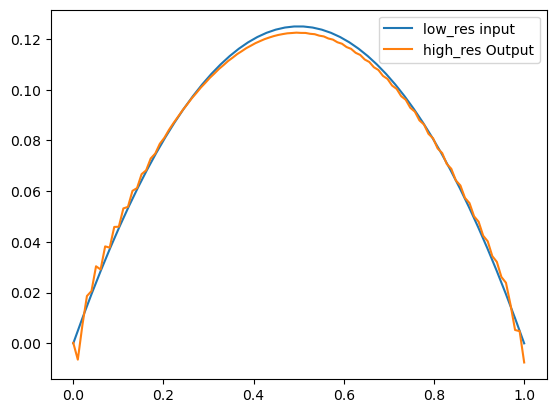

In [68]:
# Test with input A^(-1)b
model = UpScale()
model.load_state_dict(torch.load('best_model.pth'))
input = u_low
input = torch.tensor(input.reshape(1,1,-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy().reshape(-1,1)
y = output.detach().numpy().reshape(-1,1)
plt.plot(x_low,y_input,label='low_res input')
plt.plot(x_high,y,label='high_res Output')
plt.legend()
plt.show()

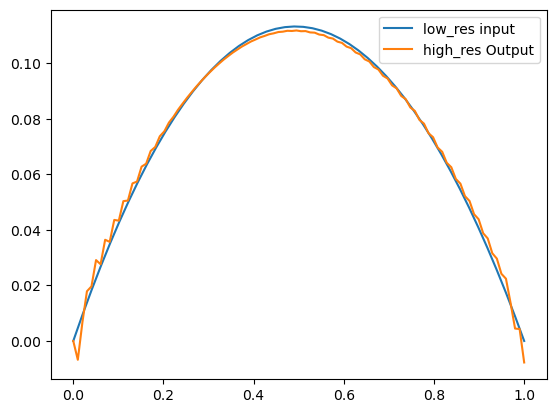

In [69]:
# Test with a random sample
model = UpScale()
model.load_state_dict(torch.load('best_model.pth'))
input = np.zeros((1,N_low))
input[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
input = torch.tensor(input.reshape(1,1,-1))
input = input.to(torch.float32)
output = model(input)
y_input = input.detach().numpy().reshape(-1,1)
y = output.detach().numpy().reshape(-1,1)
plt.plot(x_low,y_input,label='low_res input')
plt.plot(x_high,y,label='high_res Output')
plt.legend()
plt.show()

## Sampling from $p(u^l)$ and work out $log \ p(u^h|u^l)$

In [10]:
sample_ul = []
for i in range(100):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)

In [16]:
output = model(input)

In [17]:
output = output.detach().numpy()

In [20]:
output.shape

(1, 1, 40)

In [53]:
log_likelihood = []
sigma = 1
u_high = torch.tensor(u_high.reshape(1,1,-1))
u_high = u_high.to(torch.float32)
u_high = u_high.reshape(1,-1)
for i in range(100):
    input = sample_ul[i]
    input = torch.tensor(input.reshape(1,1,-1))
    input = input.to(torch.float32)
    output = model(input)
    output = output.reshape(1,-1)
    Sigma = torch.eye(N_high) * sigma
    log_lik = - N_high/2 * np.log(2*np.pi) - 0.5 * np.log(torch.linalg.det(Sigma)) - 0.5 * torch.matmul(torch.matmul(output-u_high,torch.linalg.inv(Sigma)),torch.transpose(output-u_high,0,1))
    print(torch.matmul(torch.matmul(output-u_high,torch.linalg.inv(Sigma)),torch.transpose(output-u_high,0,1)))
    log_likelihood.append(log_lik)
print(log_likelihood)

tensor([[3.9198]], grad_fn=<MmBackward0>)
tensor([[3.9178]], grad_fn=<MmBackward0>)
tensor([[3.9129]], grad_fn=<MmBackward0>)
tensor([[3.9082]], grad_fn=<MmBackward0>)
tensor([[3.9155]], grad_fn=<MmBackward0>)
tensor([[3.9147]], grad_fn=<MmBackward0>)
tensor([[3.9118]], grad_fn=<MmBackward0>)
tensor([[3.9133]], grad_fn=<MmBackward0>)
tensor([[3.9037]], grad_fn=<MmBackward0>)
tensor([[3.9128]], grad_fn=<MmBackward0>)
tensor([[3.9004]], grad_fn=<MmBackward0>)
tensor([[3.9189]], grad_fn=<MmBackward0>)
tensor([[3.9012]], grad_fn=<MmBackward0>)
tensor([[3.8991]], grad_fn=<MmBackward0>)
tensor([[3.9139]], grad_fn=<MmBackward0>)
tensor([[3.9197]], grad_fn=<MmBackward0>)
tensor([[3.9126]], grad_fn=<MmBackward0>)
tensor([[3.9150]], grad_fn=<MmBackward0>)
tensor([[3.9177]], grad_fn=<MmBackward0>)
tensor([[3.9038]], grad_fn=<MmBackward0>)
tensor([[3.9117]], grad_fn=<MmBackward0>)
tensor([[3.9073]], grad_fn=<MmBackward0>)
tensor([[3.9088]], grad_fn=<MmBackward0>)
tensor([[3.9276]], grad_fn=<MmBack

/tmp/ipykernel_376852/261011115.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_high = torch.tensor(u_high.reshape(1,1,-1))


In [52]:
Sigma

tensor([[0.0100, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0100, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0100, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0100]])

In [51]:
torch.linalg.det(Sigma)

tensor(0.)

In [50]:
0.5 * np.log(torch.linalg.det(Sigma))

/tmp/ipykernel_376852/1866546677.py:1: RuntimeWarning: divide by zero encountered in log
  0.5 * np.log(torch.linalg.det(Sigma))


tensor(-inf)

In [31]:
input = sample_ul[0]
input = torch.tensor(input.reshape(1,1,-1))
input = input.to(torch.float32)
output = model(input)
Sigma = torch.eye(N_high) * 0.01

In [38]:
output = output.reshape(1,-1)
u_high = u_high.reshape(1,-1)

In [47]:
torch.matmul(torch.matmul(output-u_high,torch.linalg.inv(Sigma)),torch.transpose(output-u_high,0,1))

tensor([[390.2947]], grad_fn=<MmBackward0>)

In [40]:
torch.matmul(output-u_high,torch.linalg.inv(Sigma)).shape

torch.Size([1, 100])

In [37]:
torch.transpose(output-u_high,0,1).shape

torch.Size([1, 1, 100])

In [18]:
u_high = torch.tensor(u_high.reshape(1,1,-1))
u_high = u_high.to(torch.float32)
print(u_high.shape)

torch.Size([1, 1, 100])


/tmp/ipykernel_376852/3026803364.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u_high = torch.tensor(u_high.reshape(1,1,-1))


In [24]:
output = output.reshape(1,-1)

In [26]:
output.shape

torch.Size([1, 100])

In [28]:
torch.transpose(output,0,1).shape

torch.Size([100, 1])

In [9]:
log_likelihood = []
sigma = 0.01
u_high = torch.tensor(u_high.reshape(1,1,-1))
u_high = u_high.to(torch.float32)
for i in range(100):
    input = sample_ul[i]
    input = torch.tensor(input.reshape(1,1,-1))
    input = input.to(torch.float32)
    output = model(input)
    log_lik = np.log(1/(sigma*np.sqrt(2*torch.pi))) - 0.5 * (u_high-output/sigma)**2
    log_likelihood.append(torch.sum(log_lik))

## Work out the log marginal likelihood

In [221]:
max_likelihood = max(log_likelihood)
log_marginal = max_likelihood
value = 0
for i in range(100):
    value += 0.1 * torch.exp(log_likelihood[i]-max_likelihood)
log_marginal += torch.log(value)

In [222]:
log_marginal

tensor(149.4148, grad_fn=<AddBackward0>)

In [50]:
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
sigma = 0.01
N_samples = 1000
u_high = torch.tensor(u_high.reshape(1,1,-1))
u_high = u_high.to(torch.float32)

sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)

for epoch in range(1000):
    # Calculate log likelihood based on all low-resolution samples
    log_likelihood = []
    max_index = 0
    log_lik_max = 0
    for i in range(N_samples):
        input = sample_ul[i]
        input = torch.tensor(input.reshape(1,1,-1))
        input = input.to(torch.float32)
        output = model(input)
        log_lik = np.log(1/(sigma*np.sqrt(2*torch.pi))) - 0.5 * ((u_high-output)/sigma)**2
        log_likelihood.append(log_lik)
        if torch.sum(log_lik) > log_lik_max:
            max_index = i
            log_lik_max = torch.sum(log_lik)
    
    # Calculate log marginal likelihood
    max_likelihood = log_likelihood[max_index]
    value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
    for i in range(1,N_samples):
        value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
    log_marginal = max_likelihood + torch.log(value)
    
    
    # loss = -sum(log_likelihood)
    
    optim.zero_grad()
    loss = -torch.sum(log_marginal)
    loss.backward()
    optim.step()
    
    if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))

Epoch: 99 Loss: 188.5106964111328
Epoch: 199 Loss: 8.155023574829102
Epoch: 299 Loss: -128.54312133789062
Epoch: 399 Loss: -216.32875061035156
Epoch: 499 Loss: -261.1813049316406
Epoch: 599 Loss: -281.7933349609375
Epoch: 699 Loss: -292.56622314453125
Epoch: 799 Loss: -299.8423767089844
Epoch: 899 Loss: -305.23150634765625
Epoch: 999 Loss: -309.7376708984375


In [64]:
output = model(input)

In [65]:
input

tensor([[[0.0000, 0.0108, 0.0212, 0.0312, 0.0408, 0.0499, 0.0586, 0.0669,
          0.0748, 0.0822, 0.0891, 0.0957, 0.1017, 0.1074, 0.1125, 0.1172,
          0.1215, 0.1253, 0.1286, 0.1315, 0.1338, 0.1358, 0.1372, 0.1382,
          0.1387, 0.1387, 0.1383, 0.1374, 0.1360, 0.1341, 0.1318, 0.1290,
          0.1257, 0.1220, 0.1178, 0.1131, 0.1080, 0.1024, 0.0963, 0.0898,
          0.0829, 0.0754, 0.0676, 0.0592, 0.0505, 0.0413, 0.0316, 0.0215,
          0.0110, 0.0000]]])

In [66]:
output

tensor([[[-0.0272,  0.0058, -0.0016,  0.0150,  0.0264,  0.0246,  0.0345,
           0.0341,  0.0429,  0.0435,  0.0510,  0.0525,  0.0587,  0.0611,
           0.0660,  0.0693,  0.0730,  0.0770,  0.0796,  0.0843,  0.0858,
           0.0912,  0.0917,  0.0976,  0.0977,  0.1037,  0.1031,  0.1083,
           0.1075,  0.1119,  0.1115,  0.1152,  0.1151,  0.1182,  0.1183,
           0.1208,  0.1212,  0.1231,  0.1237,  0.1251,  0.1258,  0.1267,
           0.1276,  0.1281,  0.1290,  0.1291,  0.1300,  0.1297,  0.1307,
           0.1301,  0.1310,  0.1301,  0.1309,  0.1297,  0.1304,  0.1291,
           0.1296,  0.1281,  0.1284,  0.1268,  0.1268,  0.1252,  0.1248,
           0.1232,  0.1225,  0.1209,  0.1198,  0.1183,  0.1167,  0.1153,
           0.1133,  0.1121,  0.1095,  0.1085,  0.1057,  0.1046,  0.1016,
           0.0996,  0.0967,  0.0935,  0.0911,  0.0867,  0.0852,  0.0795,
           0.0789,  0.0719,  0.0722,  0.0638,  0.0651,  0.0552,  0.0576,
           0.0463,  0.0498,  0.0369,  0.0419,  0.02

In [67]:
y = output.detach().numpy().reshape(-1,1)

In [68]:
x_high.shape

(100,)

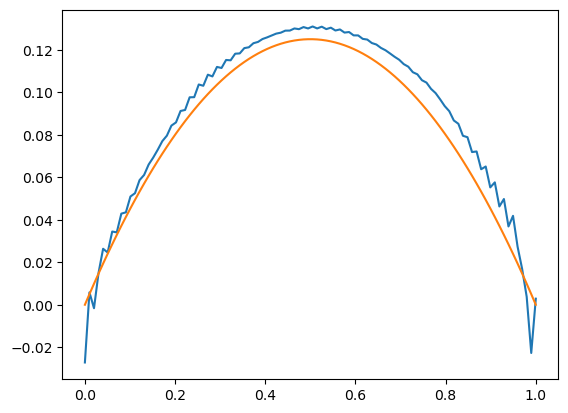

In [69]:
plt.plot(x_high,y)
plt.plot(x_high,u_high)

In [62]:
model = UpScale()
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
sigma = 1
Sigma = torch.eye(N_high) * sigma
N_samples = 100
u_high = torch.tensor(u_high.reshape(1,1,-1))
u_high = u_high.to(torch.float32)
u_high = u_high.reshape(1,-1)

sample_ul = []
for i in range(N_samples):
    u = np.zeros((1,N_low))
    u[0,1:N_low-1] = np.random.multivariate_normal(mean_u.ravel(),covariance_u).reshape(1,-1)
    sample_ul.append(u)

for epoch in range(1000):
    # Calculate log likelihood based on all low-resolution samples
    log_likelihood = []
    max_index = 0
    log_lik_max = 0
    for i in range(N_samples):
        input = sample_ul[i]
        input = torch.tensor(input.reshape(1,1,-1))
        input = input.to(torch.float32)
        output = model(input)
        output = output.reshape(1,-1)
        log_lik = - 0.5 * torch.matmul(torch.matmul(output-u_high,torch.linalg.inv(Sigma)),torch.transpose(output-u_high,0,1))
        log_likelihood.append(log_lik)
        if log_lik > log_lik_max:
            max_index = i
            log_lik_max = log_lik
    
    # Calculate log marginal likelihood
    max_likelihood = log_likelihood[max_index]
    value = torch.exp(log_likelihood[0]-max_likelihood)/N_samples
    for i in range(1,N_samples):
        value += torch.exp(log_likelihood[i]-max_likelihood)/N_samples
    log_marginal = max_likelihood + torch.log(value)
    
    
    # loss = -sum(log_likelihood)
    
    optim.zero_grad()
    loss = -log_marginal
    loss.backward()
    optim.step()
    
    if (epoch+1)%100 == 0:
        print("Epoch: {}".format(epoch), "Loss: {}".format(loss.item()))

Epoch: 99 Loss: 0.0521715022623539
Epoch: 199 Loss: 0.027179189026355743
Epoch: 299 Loss: 0.012188955210149288
Epoch: 399 Loss: 0.009212561883032322
Epoch: 499 Loss: 0.007285407278686762
Epoch: 599 Loss: 0.006097985431551933
Epoch: 699 Loss: 0.005433752667158842
Epoch: 799 Loss: 0.004743998870253563
Epoch: 899 Loss: 0.00444452092051506
Epoch: 999 Loss: 0.004234673455357552


In [ ]:
log_likelihood = []
sigma = 1
u_high = torch.tensor(u_high.reshape(1,1,-1))
u_high = u_high.to(torch.float32)
u_high = u_high.reshape(1,-1)
for i in range(100):
    input = sample_ul[i]
    input = torch.tensor(input.reshape(1,1,-1))
    input = input.to(torch.float32)
    output = model(input)
    output = output.reshape(1,-1)
    Sigma = torch.eye(N_high) * sigma
    log_lik = - N_high/2 * np.log(2*np.pi) - 0.5 * np.log(torch.linalg.det(Sigma)) - 0.5 * torch.matmul(torch.matmul(output-u_high,torch.linalg.inv(Sigma)),torch.transpose(output-u_high,0,1))
    print(torch.matmul(torch.matmul(output-u_high,torch.linalg.inv(Sigma)),torch.transpose(output-u_high,0,1)))
    log_likelihood.append(log_lik)
print(log_likelihood)

In [125]:
log_marginal

tensor(11.1253, grad_fn=<AddBackward0>)

In [123]:
max(log_likelihood)

tensor(13.1246, grad_fn=<SumBackward0>)

In [120]:
log_likelihood

[tensor(5.1212, grad_fn=<SumBackward0>),
 tensor(5.8869, grad_fn=<SumBackward0>),
 tensor(8.7705, grad_fn=<SumBackward0>),
 tensor(10.6620, grad_fn=<SumBackward0>),
 tensor(8.6364, grad_fn=<SumBackward0>),
 tensor(13.1246, grad_fn=<SumBackward0>),
 tensor(9.3803, grad_fn=<SumBackward0>),
 tensor(8.1182, grad_fn=<SumBackward0>),
 tensor(9.7726, grad_fn=<SumBackward0>),
 tensor(11.4015, grad_fn=<SumBackward0>)]

In [109]:
input = sample_ul[0]
input = torch.tensor(input.reshape(1,1,-1))
input = input.to(torch.float32)
output = model(torch.tensor(input.reshape(1,1,-1)))
output.shape

/tmp/ipykernel_194561/2390931610.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(input.reshape(1,1,-1)))


torch.Size([1, 1, 80])

In [110]:
u_high.shape

(80, 1)